In [4]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from holotomocupy.holo import G
from holotomocupy.utils import *

%matplotlib inline

np.random.seed(10)

In [5]:
n = 2048  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3-sx0])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'

## Make probe at the coded aperture position

File ‘data/prb_id16a/prb_abs_2048.tiff’ already there; not retrieving.

File ‘data/prb_id16a/prb_phase_2048.tiff’ already there; not retrieving.



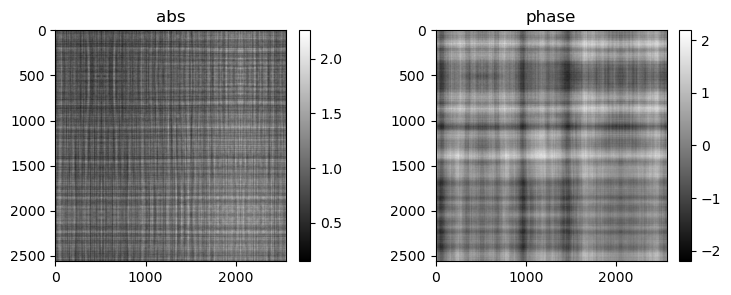

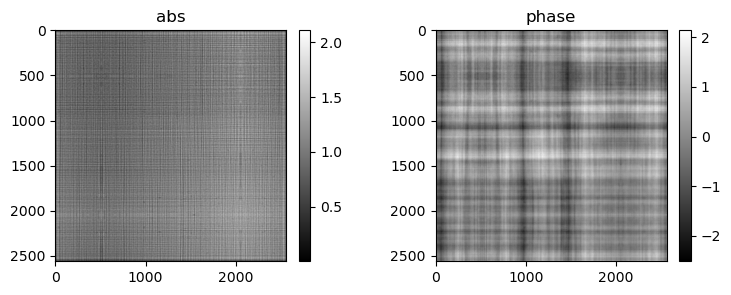

In [6]:
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_abs_2048.tiff -P data/prb_id16a
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_phase_2048.tiff -P data/prb_id16a

prb_abs = read_tiff(f'data/prb_id16a/prb_abs_2048.tiff')[0:1]
prb_phase = read_tiff(f'data/prb_id16a/prb_phase_2048.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')


prb = np.pad(prb[:,pad:-pad,pad:-pad],((0,0),(2*pad,2*pad),(2*pad,2*pad)),'symmetric')#prb[:, 128-pad:-128+pad, 128-pad:-128+pad]
prb /= np.mean(np.abs(prb))

v = np.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-10*(vx**2+vy**2))
prb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb)))
prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
prb = prb.astype('complex64')

# initial probe
mshow_polar(prb[0],show)
# probe at the code place
prb = G(cp.array(prb),wavelength,voxelsize,-distances2[0])
mshow_polar(prb[0],show)

write_tiff(np.abs(prb),f'{flg}/prb_abs_2048_code.tiff')
write_tiff(np.angle(prb),f'{flg}/prb_phase_2048_code.tiff')